In [1]:
# Importing all the necessary libraries for the project
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.optim.optimizer import Optimizer
from torch.optim import Adam
from collections import defaultdict

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets.vision import VisionDataset

import os
from tqdm import tqdm
from typing import Any, Callable, Optional, Tuple, Union
from pathlib import Path
from PIL import Image
import pandas as pd

In [2]:
# Setting seed values for reproducibility

seed = 1029
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# some cudnn methods can be random even after fixing the seed
# unless you tell it to be deterministic
torch.backends.cudnn.deterministic = True

#### Defining Parameters and Hyperparameters

In [3]:
# Defining variables, parameters and hyperparameters for the run

run_on_kaggle = 1                           # Set this to 1 if running on Kaggle, 0 if running on local machine

# Setting up the data directories and model save path based on the run environment
if run_on_kaggle:
    train_data_dir = '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python'
    val_data_dir = '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python'
    test_data_dir = '/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl'
    model_save_path = './'
    num_of_workers = 16
    download_data = False

else:
    base_dir = './data'
    train_data_dir = './data/cifar-10-batches-py'
    val_data_dir = './data/cifar-10-batches-py'
    test_data_dir = './data/cifar_test_nolabel.pkl'
    model_save_path = './checkpoint'
    num_of_workers = 0
    download_data = False

    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
    
    if not os.path.exists(train_data_dir):
        download_data = True
        train_data_dir = './data'
        val_data_dir = './data'
    
    if not os.path.exists(val_data_dir):
        download_data = True
    
    if not os.path.exists(test_data_dir):
       print("No Label Test Data not found")


# Defining Parameters and Hyperparameters
train_batch_size = 128
val_batch_size = 100
test_batch_size = 100
num_epochs = 200
learning_rate = 0.1
momentum = 0.9
weight_decay = 5e-4
cosine_annealing_T_max = num_epochs


# Defining Model Configurations and Techniques
use_cutout = 1                              # Set this to 1 if using Cutout, 0 if not using Cutout
use_mixup = 0                               # Set this to 1 if using Mixup, 0 if not using Mixup
use_label_smoothing = 1                     # Set this to 1 if using Label Smoothing, 0 if not using Label Smoothing
use_lookahead = 1                           # Set this to 1 if using Lookahead, 0 if not using Lookahead


if use_cutout:
    cutout_n_holes = 1
    cutout_length = 8

if use_mixup:
    mixup_alpha = 0.75

if use_label_smoothing:
    label_smoothing_epsilon = 0.2

if use_lookahead:
    lookahead_k = 5
    lookahead_alpha = 0.5

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
# Cutout Implementation for Data Augmentation
class Cutout(object):
    """Randomly mask out one or more patches from an image.

    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

def prepare_data(train_data_dir, val_data_dir):
    '''
    Function to prepare the data for training and validation. This will return the train and validation loader.
    It will also apply data augmentation and data normalization to the data.
    '''

    # Data Augmentation and Transformation for the Training Data
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    # Data Transformation with Cutout for the Training Data
    train_transform_cutout = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        Cutout(n_holes=cutout_n_holes, length=cutout_length)
    ])

    # Data Augmentation and Transformation for the Validation Data
    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    if use_cutout:
        final_train_transform = train_transform_cutout
    else:
        final_train_transform = train_transform

    # Loading the CIFAR-10 Training and Validation Data
    train_dataset = torchvision.datasets.CIFAR10(root=train_data_dir, train=True, download=download_data, transform=final_train_transform)
    val_dataset = torchvision.datasets.CIFAR10(root=val_data_dir, train=False, download=download_data, transform=val_transform)

    # Creating the Data Loaders for Training and Validation
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=num_of_workers)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=num_of_workers)

    return train_loader, val_loader

In [6]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, kernel=3, shortcut_kernel=1, dropout = 0.0):
        super(BasicBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=shortcut_kernel, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        # Apply first convolution, batch norm, and ReLU
        out = F.relu(self.bn1(self.conv1(x)))
        # Apply second convolution and batch norm
        out = self.bn2(self.conv2(out))
        # Add shortcut connection
        out += self.shortcut(x)
        # Apply final ReLU
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, channels, strides, kernel_size, shortcut_kernel_size, pool_size, dropout, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = channels[0]
        self.kernel_size = kernel_size
        self.shortcut_kernel_size = shortcut_kernel_size
        self.pool_size = pool_size

        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels[0])


        self.layers = nn.ModuleList()
        for i in range(len(num_blocks)):
            self.layers.append(
                self._make_layer(block[i], channels[i], num_blocks[i], stride=strides[i], dropout = dropout)
            )

        # Fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(channels[-1] * block[-1].expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride, dropout):
        strides = [stride] + [1] * (num_blocks - 1)  # First block uses the specified stride, others use stride=1
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride, self.kernel_size, self.shortcut_kernel_size, dropout))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # Apply initial convolution, batch norm, and ReLU
        out = F.relu(self.bn1(self.conv1(x)))

        # Pass through all layers
        for layer in self.layers:
            out = layer(out)

        # Apply average pooling and flatten
        out = self.avgpool(out)
        out = torch.flatten(out, 1)

        # Apply fully connected layer
        out = self.dropout(out)
        out = self.linear(out)
        return out

#### Defining model architecture

In [7]:
# Defining the ResNet Model Architecture
type_of_block_used = [BasicBlock, BasicBlock, BasicBlock]
num_of_blocks = [4, 5, 3]
num_of_channels = [64, 128, 256]
strides_per_block = [1, 2, 2]
kernel_size = 3
shortcut_kernel_size = 1
pool_size = 8
dropout = 0.0

# Creating the ResNet Model
model = ResNet(type_of_block_used, num_of_blocks, num_of_channels, strides_per_block, kernel_size, shortcut_kernel_size, pool_size, dropout).to(device)

In [8]:
# Checking the model summary and total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
if total_params > 5000000:
    raise Exception("Model size exceeds 5 million parameters")

# Checking the model summary
summary(model, (3, 32, 32))

4,992,586 total parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      Batch

In [9]:
# Added Lookahead Optimizer
class Lookahead(Optimizer):
    def __init__(self, base_optimizer, alpha=0.5, k=6):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        defaults = dict(lookahead_alpha=alpha, lookahead_k=k, lookahead_step=0)
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        self.defaults = base_optimizer.defaults
        self.defaults.update(defaults)
        self.state = defaultdict(dict)
        # manually add our defaults to the param groups
        for name, default in defaults.items():
            for group in self.param_groups:
                group.setdefault(name, default)

    def update_slow(self, group):
        for fast_p in group["params"]:
            if fast_p.grad is None:
                continue
            param_state = self.state[fast_p]
            if 'slow_buffer' not in param_state:
                param_state['slow_buffer'] = torch.empty_like(fast_p.data)
                param_state['slow_buffer'].copy_(fast_p.data)
            slow = param_state['slow_buffer']
            slow.add_(group['lookahead_alpha'], fast_p.data - slow)
            fast_p.data.copy_(slow)

    def sync_lookahead(self):
        for group in self.param_groups:
            self.update_slow(group)

    def step(self, closure=None):
        # print(self.k)
        #assert id(self.param_groups) == id(self.base_optimizer.param_groups)
        loss = self.base_optimizer.step(closure)
        for group in self.param_groups:
            group['lookahead_step'] += 1
            if group['lookahead_step'] % group['lookahead_k'] == 0:
                self.update_slow(group)
        return loss

    def state_dict(self):
        fast_state_dict = self.base_optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict['state']
        param_groups = fast_state_dict['param_groups']
        return {
            'state': fast_state,
            'slow_state': slow_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        fast_state_dict = {
            'state': state_dict['state'],
            'param_groups': state_dict['param_groups'],
        }
        self.base_optimizer.load_state_dict(fast_state_dict)

        # We want to restore the slow state, but share param_groups reference
        # with base_optimizer. This is a bit redundant but least code
        slow_state_new = False
        if 'slow_state' not in state_dict:
            print('Loading state_dict from optimizer without Lookahead applied.')
            state_dict['slow_state'] = defaultdict(dict)
            slow_state_new = True
        slow_state_dict = {
            'state': state_dict['slow_state'],
            'param_groups': state_dict['param_groups'],  # this is pointless but saves code
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.param_groups = self.base_optimizer.param_groups  # make both ref same container
        if slow_state_new:
            # reapply defaults to catch missing lookahead specific ones
            for name, default in self.defaults.items():
                for group in self.param_groups:
                    group.setdefault(name, default)

In [10]:
def mixup_data(x, y, alpha=32):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]

    index = torch.randperm(batch_size).cuda()
  

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [11]:
# Defining Label Smoothing Cross Entropy Loss
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, eps=0.05, reduction='mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.eps = eps
        self.reduction = reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum':
            loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':
                loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, reduction=self.reduction)

In [12]:
def check_gradient_norms(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)  # L2 norm of gradients
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1.0 / 2)  # Total L2 norm
    return total_norm

In [13]:
# Defining lists to store the training and validation losses, accuracies and gradient norms to plot later
train_losses = []
gradients_norms = []
train_acc = []
test_losses_l1 = []
test_acc_l1 = []
plot_train_loss = []
plot_test_loss = []
plot_gradient_norms = []

best_acc = 0


In [14]:
def train_for_one_epoch(model, device, train_loader, optimizer):
    model.to(device)

    model.train()

    pbar = tqdm(train_loader)

    correct = 0
    processed = 0
    train_loss_accu = 0
    grad_norm_accu = 0

    # Choose the loss function based on whether label smoothing is enabled
    if use_label_smoothing:
        criterion = LabelSmoothingCrossEntropy(eps=label_smoothing_epsilon)
    else:
        criterion = nn.CrossEntropyLoss()
    
    # Iterate over the training data in batches
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        # Apply mixup augmentation if enabled
        if use_mixup:
            data, targets_a, targets_b, lam = mixup_data(data, target, mixup_alpha)
        
        optimizer.zero_grad()
        y_pred = model(data)

        # Compute the loss based on whether mixup is enabled
        if use_mixup:
            loss = mixup_criterion(criterion, y_pred, targets_a, targets_b, lam)
        else:
            loss = criterion(y_pred, target)

        # Accumulate the loss for the epoch
        train_loss_accu += loss.item()
        # Append the current loss to the list of training losses
        train_losses.append(loss)

        # Backward pass: compute gradients
        loss.backward()

        # Accumulate gradient norms and append to the list of gradient norms
        grad_norm_accu += check_gradient_norms(model)
        gradients_norms.append(check_gradient_norms(model))

        # Update model parameters using the optimizer
        optimizer.step()

        # Compute predictions and update accuracy counters
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        pbar.set_description(desc= f'Loss={loss.item()}\tAccuracy={100*correct/processed:0.2f}\tGradient Norm={grad_norm_accu/(batch_idx+1):0.2f}')

    # Append the epoch's accuracy, average loss, and average gradient norm to their respective lists
    train_acc.append(100*correct/processed)
    plot_train_loss.append(train_loss_accu/len(train_loader))
    plot_gradient_norms.append(grad_norm_accu/len(train_loader))

    # Print the epoch's average loss, accuracy, and gradient norm
    print(f'Epoch Loss = {train_loss_accu/len(train_loader)} \t Epoch Accuracy = {100*correct/processed:0.2f} \t Gradient Norm = {grad_norm_accu/len(train_loader):0.2f}')

In [15]:
def evaluate(model ,device, test_loader):
    model.eval()
    average_test_loss = 0
    test_loss = 0
    correct = 0

    global best_acc

    # Choose the loss function based on whether label smoothing is enabled
    if use_label_smoothing:
        criterion = LabelSmoothingCrossEntropy(eps=label_smoothing_epsilon)
    else:
        criterion = nn.CrossEntropyLoss()
    
    # Iterate over the validation data in batches for inference
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    # Calculate the average loss and accuracy for the validation data and print the results
    average_test_loss = test_loss/len(test_loader.dataset)
    test_losses_l1.append(average_test_loss)

    print("Validation Metrics: Average Loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
        average_test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc_l1.append(100. * correct / len(test_loader.dataset))

    # Save the model if the current accuracy is the best so far
    if 100. * correct / len(test_loader.dataset) > best_acc:
        best_acc = 100. * correct / len(test_loader.dataset)
        model.cpu()
        model_scripted = torch.jit.script(model)
        model_scripted.save(os.path.join(model_save_path, 'best_model.pt'))
        print(f"Model saved with accuracy {best_acc}")

In [16]:
def train_model(model, device):

    print("Preparing Data")
    train_loader, val_loader = prepare_data(train_data_dir, val_data_dir)

    # Choose the optimizer based on whether lookahead is enabled
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    if use_lookahead:
        optimizer = Lookahead(optimizer, alpha=lookahead_alpha, k=lookahead_k)

    # Scheduler for Cosine Annealing
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cosine_annealing_T_max)
    
    # Train the model for the specified number of epochs
    
    print("Starting Training")
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}")
        train_for_one_epoch(model, device, train_loader, optimizer)
        evaluate(model, device, val_loader)
        scheduler.step()

In [17]:
train_model(model, device)

Preparing Data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Starting Training
Epoch 1


Loss=3.635218381881714	Accuracy=10.35	Gradient Norm=6.94:   1%|          | 4/391 [00:02<02:34,  2.51it/s]<ipython-input-9-259e020e3a29>:28: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1642.)
  slow.add_(group['lookahead_alpha'], fast_p.data - slow)
Loss=2.003054618835449	Accuracy=25.35	Gradient Norm=1.05: 100%|██████████| 391/391 [00:45<00:00,  8.62it/s]

Epoch Loss = 2.136485361382175 	 Epoch Accuracy = 25.35 	 Gradient Norm = 1.05


Validation Metrics: Average Loss: 0.0186, Accuracy: 4103/10000 (41.03%)
Model saved with accuracy 41.03
Epoch 2


Loss=1.7127599716186523	Accuracy=39.99	Gradient Norm=1.04: 100%|██████████| 391/391 [00:44<00:00,  8.72it/s]

Epoch Loss = 1.8963086193479846 	 Epoch Accuracy = 39.99 	 Gradient Norm = 1.04


Validation Metrics: Average Loss: 0.0177, Accuracy: 4938/10000 (49.38%)
Model saved with accuracy 49.38
Epoch 3


Loss=1.604331135749817	Accuracy=50.65	Gradient Norm=1.11: 100%|██████████| 391/391 [00:45<00:00,  8.59it/s]

Epoch Loss = 1.7352860019639935 	 Epoch Accuracy = 50.65 	 Gradient Norm = 1.11


Validation Metrics: Average Loss: 0.0172, Accuracy: 5228/10000 (52.28%)
Model saved with accuracy 52.28
Epoch 4


Loss=1.6505277156829834	Accuracy=57.11	Gradient Norm=1.14: 100%|██████████| 391/391 [00:44<00:00,  8.70it/s]

Epoch Loss = 1.6307837832004517 	 Epoch Accuracy = 57.11 	 Gradient Norm = 1.14


Validation Metrics: Average Loss: 0.0177, Accuracy: 5451/10000 (54.51%)
Model saved with accuracy 54.51
Epoch 5


Loss=1.7083052396774292	Accuracy=62.52	Gradient Norm=1.18: 100%|██████████| 391/391 [00:45<00:00,  8.64it/s]

Epoch Loss = 1.5447294172423576 	 Epoch Accuracy = 62.52 	 Gradient Norm = 1.18


Validation Metrics: Average Loss: 0.0134, Accuracy: 7496/10000 (74.96%)
Model saved with accuracy 74.96
Epoch 6


Loss=1.3694040775299072	Accuracy=67.01	Gradient Norm=1.20: 100%|██████████| 391/391 [00:45<00:00,  8.62it/s]

Epoch Loss = 1.4681460790317078 	 Epoch Accuracy = 67.01 	 Gradient Norm = 1.20


Validation Metrics: Average Loss: 0.0135, Accuracy: 7389/10000 (73.89%)
Epoch 7


Loss=1.3324766159057617	Accuracy=70.14	Gradient Norm=1.19: 100%|██████████| 391/391 [00:45<00:00,  8.62it/s]

Epoch Loss = 1.4149384745551497 	 Epoch Accuracy = 70.14 	 Gradient Norm = 1.19


Validation Metrics: Average Loss: 0.0133, Accuracy: 7552/10000 (75.52%)
Model saved with accuracy 75.52
Epoch 8


Loss=1.4845545291900635	Accuracy=72.27	Gradient Norm=1.20: 100%|██████████| 391/391 [00:45<00:00,  8.67it/s]

Epoch Loss = 1.37750140754768 	 Epoch Accuracy = 72.27 	 Gradient Norm = 1.20


Validation Metrics: Average Loss: 0.0131, Accuracy: 7747/10000 (77.47%)
Model saved with accuracy 77.47
Epoch 9


Loss=1.4484561681747437	Accuracy=74.10	Gradient Norm=1.19: 100%|██████████| 391/391 [00:45<00:00,  8.60it/s]

Epoch Loss = 1.3453882447898846 	 Epoch Accuracy = 74.10 	 Gradient Norm = 1.19


Validation Metrics: Average Loss: 0.0136, Accuracy: 7444/10000 (74.44%)
Epoch 10


Loss=1.3992191553115845	Accuracy=75.31	Gradient Norm=1.21: 100%|██████████| 391/391 [00:45<00:00,  8.67it/s]

Epoch Loss = 1.3211248792955637 	 Epoch Accuracy = 75.31 	 Gradient Norm = 1.21


Validation Metrics: Average Loss: 0.0119, Accuracy: 8343/10000 (83.43%)
Model saved with accuracy 83.43
Epoch 11


Loss=1.288521409034729	Accuracy=76.55	Gradient Norm=1.23: 100%|██████████| 391/391 [00:45<00:00,  8.62it/s]

Epoch Loss = 1.3006092688006818 	 Epoch Accuracy = 76.55 	 Gradient Norm = 1.23


Validation Metrics: Average Loss: 0.0122, Accuracy: 8091/10000 (80.91%)
Epoch 12


Loss=1.3631107807159424	Accuracy=77.68	Gradient Norm=1.24: 100%|██████████| 391/391 [00:44<00:00,  8.70it/s]

Epoch Loss = 1.2826975809643641 	 Epoch Accuracy = 77.68 	 Gradient Norm = 1.24


Validation Metrics: Average Loss: 0.0124, Accuracy: 7998/10000 (79.98%)
Epoch 13


Loss=1.2513329982757568	Accuracy=78.59	Gradient Norm=1.25: 100%|██████████| 391/391 [00:44<00:00,  8.73it/s]

Epoch Loss = 1.2662338631232377 	 Epoch Accuracy = 78.59 	 Gradient Norm = 1.25


Validation Metrics: Average Loss: 0.0126, Accuracy: 8011/10000 (80.11%)
Epoch 14


Loss=1.276015281677246	Accuracy=79.29	Gradient Norm=1.27: 100%|██████████| 391/391 [00:45<00:00,  8.63it/s]

Epoch Loss = 1.2508830255864527 	 Epoch Accuracy = 79.29 	 Gradient Norm = 1.27


Validation Metrics: Average Loss: 0.0132, Accuracy: 7708/10000 (77.08%)
Epoch 15


Loss=1.254976511001587	Accuracy=79.74	Gradient Norm=1.30: 100%|██████████| 391/391 [00:45<00:00,  8.67it/s]

Epoch Loss = 1.2435974965010153 	 Epoch Accuracy = 79.74 	 Gradient Norm = 1.30


Validation Metrics: Average Loss: 0.0115, Accuracy: 8496/10000 (84.96%)
Model saved with accuracy 84.96
Epoch 16


Loss=1.3744215965270996	Accuracy=80.47	Gradient Norm=1.29: 100%|██████████| 391/391 [00:45<00:00,  8.63it/s]

Epoch Loss = 1.231339533310717 	 Epoch Accuracy = 80.47 	 Gradient Norm = 1.29


Validation Metrics: Average Loss: 0.0113, Accuracy: 8678/10000 (86.78%)
Model saved with accuracy 86.78
Epoch 17


Loss=1.2755763530731201	Accuracy=80.71	Gradient Norm=1.32: 100%|██████████| 391/391 [00:45<00:00,  8.62it/s]

Epoch Loss = 1.2247394177005113 	 Epoch Accuracy = 80.71 	 Gradient Norm = 1.32


Validation Metrics: Average Loss: 0.0118, Accuracy: 8411/10000 (84.11%)
Epoch 18


Loss=1.1984832286834717	Accuracy=81.09	Gradient Norm=1.33: 100%|██████████| 391/391 [00:45<00:00,  8.61it/s]

Epoch Loss = 1.217001310394853 	 Epoch Accuracy = 81.09 	 Gradient Norm = 1.33


Validation Metrics: Average Loss: 0.0115, Accuracy: 8506/10000 (85.06%)
Epoch 19


Loss=1.3125203847885132	Accuracy=81.36	Gradient Norm=1.34: 100%|██████████| 391/391 [00:44<00:00,  8.70it/s]

Epoch Loss = 1.2135284950056344 	 Epoch Accuracy = 81.36 	 Gradient Norm = 1.34


Validation Metrics: Average Loss: 0.0120, Accuracy: 8268/10000 (82.68%)
Epoch 20


Loss=1.2386276721954346	Accuracy=81.55	Gradient Norm=1.37: 100%|██████████| 391/391 [00:44<00:00,  8.70it/s]

Epoch Loss = 1.208188328291754 	 Epoch Accuracy = 81.55 	 Gradient Norm = 1.37


Validation Metrics: Average Loss: 0.0112, Accuracy: 8693/10000 (86.93%)
Model saved with accuracy 86.93
Epoch 21


Loss=1.2813485860824585	Accuracy=82.00	Gradient Norm=1.35: 100%|██████████| 391/391 [00:45<00:00,  8.62it/s]

Epoch Loss = 1.2004629708921817 	 Epoch Accuracy = 82.00 	 Gradient Norm = 1.35


Validation Metrics: Average Loss: 0.0113, Accuracy: 8617/10000 (86.17%)
Epoch 22


Loss=1.1029969453811646	Accuracy=82.01	Gradient Norm=1.38: 100%|██████████| 391/391 [00:45<00:00,  8.65it/s]

Epoch Loss = 1.2004367207627162 	 Epoch Accuracy = 82.01 	 Gradient Norm = 1.38


Validation Metrics: Average Loss: 0.0112, Accuracy: 8625/10000 (86.25%)
Epoch 23


Loss=1.3249146938323975	Accuracy=82.46	Gradient Norm=1.38: 100%|██████████| 391/391 [00:45<00:00,  8.63it/s]

Epoch Loss = 1.1931024381266835 	 Epoch Accuracy = 82.46 	 Gradient Norm = 1.38


Validation Metrics: Average Loss: 0.0122, Accuracy: 8245/10000 (82.45%)
Epoch 24


Loss=1.2335867881774902	Accuracy=82.72	Gradient Norm=1.37: 100%|██████████| 391/391 [00:45<00:00,  8.62it/s]

Epoch Loss = 1.188064524889602 	 Epoch Accuracy = 82.72 	 Gradient Norm = 1.37


Validation Metrics: Average Loss: 0.0124, Accuracy: 8098/10000 (80.98%)
Epoch 25


Loss=1.2165675163269043	Accuracy=82.89	Gradient Norm=1.39: 100%|██████████| 391/391 [00:45<00:00,  8.65it/s]

Epoch Loss = 1.1845223489014998 	 Epoch Accuracy = 82.89 	 Gradient Norm = 1.39


Validation Metrics: Average Loss: 0.0107, Accuracy: 8947/10000 (89.47%)
Model saved with accuracy 89.47
Epoch 26


Loss=1.1882449388504028	Accuracy=83.04	Gradient Norm=1.39: 100%|██████████| 391/391 [00:45<00:00,  8.66it/s]

Epoch Loss = 1.1830596085399618 	 Epoch Accuracy = 83.04 	 Gradient Norm = 1.39


Validation Metrics: Average Loss: 0.0107, Accuracy: 8961/10000 (89.61%)
Model saved with accuracy 89.61
Epoch 27


Loss=1.1347730159759521	Accuracy=83.39	Gradient Norm=1.40: 100%|██████████| 391/391 [00:45<00:00,  8.56it/s]

Epoch Loss = 1.1758763652933224 	 Epoch Accuracy = 83.39 	 Gradient Norm = 1.40


Validation Metrics: Average Loss: 0.0114, Accuracy: 8590/10000 (85.90%)
Epoch 28


Loss=1.1762226819992065	Accuracy=83.48	Gradient Norm=1.41: 100%|██████████| 391/391 [00:45<00:00,  8.64it/s]

Epoch Loss = 1.1761546961181915 	 Epoch Accuracy = 83.48 	 Gradient Norm = 1.41


Validation Metrics: Average Loss: 0.0117, Accuracy: 8381/10000 (83.81%)
Epoch 29


Loss=1.1648151874542236	Accuracy=84.02	Gradient Norm=1.41: 100%|██████████| 391/391 [00:45<00:00,  8.61it/s]

Epoch Loss = 1.1655359295627954 	 Epoch Accuracy = 84.02 	 Gradient Norm = 1.41


Validation Metrics: Average Loss: 0.0128, Accuracy: 7912/10000 (79.12%)
Epoch 30


Loss=1.2194840908050537	Accuracy=83.98	Gradient Norm=1.43: 100%|██████████| 391/391 [00:45<00:00,  8.65it/s]

Epoch Loss = 1.1656814362386914 	 Epoch Accuracy = 83.98 	 Gradient Norm = 1.43


Validation Metrics: Average Loss: 0.0107, Accuracy: 8933/10000 (89.33%)
Epoch 31


Loss=1.040892243385315	Accuracy=84.16	Gradient Norm=1.44: 100%|██████████| 391/391 [00:45<00:00,  8.59it/s]

Epoch Loss = 1.1646066202836878 	 Epoch Accuracy = 84.16 	 Gradient Norm = 1.44


Validation Metrics: Average Loss: 0.0108, Accuracy: 8897/10000 (88.97%)
Epoch 32


Loss=1.2019034624099731	Accuracy=84.22	Gradient Norm=1.43: 100%|██████████| 391/391 [00:45<00:00,  8.64it/s]

Epoch Loss = 1.1613060534762605 	 Epoch Accuracy = 84.22 	 Gradient Norm = 1.43


Validation Metrics: Average Loss: 0.0113, Accuracy: 8712/10000 (87.12%)
Epoch 33


Loss=1.1647992134094238	Accuracy=84.17	Gradient Norm=1.44: 100%|██████████| 391/391 [00:45<00:00,  8.57it/s]

Epoch Loss = 1.160605142793387 	 Epoch Accuracy = 84.17 	 Gradient Norm = 1.44


Validation Metrics: Average Loss: 0.0113, Accuracy: 8595/10000 (85.95%)
Epoch 34


Loss=1.1324775218963623	Accuracy=84.54	Gradient Norm=1.43: 100%|██████████| 391/391 [00:45<00:00,  8.64it/s]

Epoch Loss = 1.1573270358088072 	 Epoch Accuracy = 84.54 	 Gradient Norm = 1.43


Validation Metrics: Average Loss: 0.0120, Accuracy: 8319/10000 (83.19%)
Epoch 35


Loss=1.103431224822998	Accuracy=84.55	Gradient Norm=1.44: 100%|██████████| 391/391 [00:45<00:00,  8.50it/s]

Epoch Loss = 1.156318239543749 	 Epoch Accuracy = 84.55 	 Gradient Norm = 1.44


Validation Metrics: Average Loss: 0.0106, Accuracy: 9002/10000 (90.02%)
Model saved with accuracy 90.02
Epoch 36


Loss=1.0999221801757812	Accuracy=84.85	Gradient Norm=1.44: 100%|██████████| 391/391 [00:45<00:00,  8.64it/s]

Epoch Loss = 1.152280125166754 	 Epoch Accuracy = 84.85 	 Gradient Norm = 1.44


Validation Metrics: Average Loss: 0.0105, Accuracy: 9030/10000 (90.30%)
Model saved with accuracy 90.3
Epoch 37


Loss=1.1651294231414795	Accuracy=84.83	Gradient Norm=1.45: 100%|██████████| 391/391 [00:45<00:00,  8.54it/s]

Epoch Loss = 1.1505937716540169 	 Epoch Accuracy = 84.83 	 Gradient Norm = 1.45


Validation Metrics: Average Loss: 0.0109, Accuracy: 8831/10000 (88.31%)
Epoch 38


Loss=1.26128351688385	Accuracy=85.20	Gradient Norm=1.45: 100%|██████████| 391/391 [00:45<00:00,  8.60it/s]

Epoch Loss = 1.1443585398252054 	 Epoch Accuracy = 85.20 	 Gradient Norm = 1.45


Validation Metrics: Average Loss: 0.0118, Accuracy: 8451/10000 (84.51%)
Epoch 39


Loss=1.1119961738586426	Accuracy=85.17	Gradient Norm=1.46: 100%|██████████| 391/391 [00:45<00:00,  8.57it/s]

Epoch Loss = 1.1440640971483782 	 Epoch Accuracy = 85.17 	 Gradient Norm = 1.46


Validation Metrics: Average Loss: 0.0111, Accuracy: 8763/10000 (87.63%)
Epoch 40


Loss=1.0778350830078125	Accuracy=85.35	Gradient Norm=1.46: 100%|██████████| 391/391 [00:45<00:00,  8.61it/s]

Epoch Loss = 1.143448944286922 	 Epoch Accuracy = 85.35 	 Gradient Norm = 1.46


Validation Metrics: Average Loss: 0.0105, Accuracy: 9032/10000 (90.32%)
Model saved with accuracy 90.32
Epoch 41


Loss=1.1531248092651367	Accuracy=85.14	Gradient Norm=1.48: 100%|██████████| 391/391 [00:45<00:00,  8.55it/s]

Epoch Loss = 1.1438654661178589 	 Epoch Accuracy = 85.14 	 Gradient Norm = 1.48


Validation Metrics: Average Loss: 0.0108, Accuracy: 8915/10000 (89.15%)
Epoch 42


Loss=1.0591572523117065	Accuracy=85.31	Gradient Norm=1.47: 100%|██████████| 391/391 [00:45<00:00,  8.55it/s]

Epoch Loss = 1.141725478269865 	 Epoch Accuracy = 85.31 	 Gradient Norm = 1.47


Validation Metrics: Average Loss: 0.0108, Accuracy: 8871/10000 (88.71%)
Epoch 43


Loss=1.1019458770751953	Accuracy=85.60	Gradient Norm=1.47: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]

Epoch Loss = 1.136297364673956 	 Epoch Accuracy = 85.60 	 Gradient Norm = 1.47


Validation Metrics: Average Loss: 0.0112, Accuracy: 8718/10000 (87.18%)
Epoch 44


Loss=1.2165613174438477	Accuracy=85.48	Gradient Norm=1.49: 100%|██████████| 391/391 [00:45<00:00,  8.56it/s]

Epoch Loss = 1.1359492887926224 	 Epoch Accuracy = 85.48 	 Gradient Norm = 1.49


Validation Metrics: Average Loss: 0.0119, Accuracy: 8394/10000 (83.94%)
Epoch 45


Loss=1.1415461301803589	Accuracy=85.65	Gradient Norm=1.48: 100%|██████████| 391/391 [00:45<00:00,  8.53it/s]

Epoch Loss = 1.134340782604559 	 Epoch Accuracy = 85.65 	 Gradient Norm = 1.48


Validation Metrics: Average Loss: 0.0104, Accuracy: 9097/10000 (90.97%)
Model saved with accuracy 90.97
Epoch 46


Loss=1.0942784547805786	Accuracy=85.64	Gradient Norm=1.48: 100%|██████████| 391/391 [00:45<00:00,  8.59it/s]

Epoch Loss = 1.1345206020433274 	 Epoch Accuracy = 85.64 	 Gradient Norm = 1.48


Validation Metrics: Average Loss: 0.0105, Accuracy: 9001/10000 (90.01%)
Epoch 47


Loss=1.010474443435669	Accuracy=86.01	Gradient Norm=1.48: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]

Epoch Loss = 1.1278475208965408 	 Epoch Accuracy = 86.01 	 Gradient Norm = 1.48


Validation Metrics: Average Loss: 0.0107, Accuracy: 9003/10000 (90.03%)
Epoch 48


Loss=1.095969319343567	Accuracy=86.22	Gradient Norm=1.50: 100%|██████████| 391/391 [00:45<00:00,  8.61it/s]

Epoch Loss = 1.1263374431663766 	 Epoch Accuracy = 86.22 	 Gradient Norm = 1.50


Validation Metrics: Average Loss: 0.0110, Accuracy: 8816/10000 (88.16%)
Epoch 49


Loss=1.1865378618240356	Accuracy=86.06	Gradient Norm=1.51: 100%|██████████| 391/391 [00:46<00:00,  8.47it/s]

Epoch Loss = 1.1277710156672447 	 Epoch Accuracy = 86.06 	 Gradient Norm = 1.51


Validation Metrics: Average Loss: 0.0113, Accuracy: 8622/10000 (86.22%)
Epoch 50


Loss=1.0702641010284424	Accuracy=86.32	Gradient Norm=1.50: 100%|██████████| 391/391 [00:45<00:00,  8.57it/s]

Epoch Loss = 1.1241365954699114 	 Epoch Accuracy = 86.32 	 Gradient Norm = 1.50


Validation Metrics: Average Loss: 0.0103, Accuracy: 9136/10000 (91.36%)
Model saved with accuracy 91.36
Epoch 51


Loss=1.133635401725769	Accuracy=86.32	Gradient Norm=1.52: 100%|██████████| 391/391 [00:45<00:00,  8.50it/s]

Epoch Loss = 1.124924771011333 	 Epoch Accuracy = 86.32 	 Gradient Norm = 1.52


Validation Metrics: Average Loss: 0.0108, Accuracy: 8933/10000 (89.33%)
Epoch 52


Loss=1.0676769018173218	Accuracy=86.56	Gradient Norm=1.50: 100%|██████████| 391/391 [00:45<00:00,  8.54it/s]

Epoch Loss = 1.1189895321036238 	 Epoch Accuracy = 86.56 	 Gradient Norm = 1.50


Validation Metrics: Average Loss: 0.0108, Accuracy: 8911/10000 (89.11%)
Epoch 53


Loss=1.0489122867584229	Accuracy=86.52	Gradient Norm=1.51: 100%|██████████| 391/391 [00:45<00:00,  8.57it/s]

Epoch Loss = 1.12056726720327 	 Epoch Accuracy = 86.52 	 Gradient Norm = 1.51


Validation Metrics: Average Loss: 0.0107, Accuracy: 8922/10000 (89.22%)
Epoch 54


Loss=1.0655958652496338	Accuracy=86.65	Gradient Norm=1.52: 100%|██████████| 391/391 [00:45<00:00,  8.59it/s]

Epoch Loss = 1.1179160166274555 	 Epoch Accuracy = 86.65 	 Gradient Norm = 1.52


Validation Metrics: Average Loss: 0.0109, Accuracy: 8854/10000 (88.54%)
Epoch 55


Loss=1.1857428550720215	Accuracy=86.52	Gradient Norm=1.54: 100%|██████████| 391/391 [00:45<00:00,  8.56it/s]

Epoch Loss = 1.1186292616607587 	 Epoch Accuracy = 86.52 	 Gradient Norm = 1.54


Validation Metrics: Average Loss: 0.0104, Accuracy: 9147/10000 (91.47%)
Model saved with accuracy 91.47
Epoch 56


Loss=1.0435329675674438	Accuracy=86.82	Gradient Norm=1.53: 100%|██████████| 391/391 [00:45<00:00,  8.54it/s]

Epoch Loss = 1.115560110572659 	 Epoch Accuracy = 86.82 	 Gradient Norm = 1.53


Validation Metrics: Average Loss: 0.0104, Accuracy: 9128/10000 (91.28%)
Epoch 57


Loss=1.1087725162506104	Accuracy=86.76	Gradient Norm=1.53: 100%|██████████| 391/391 [00:45<00:00,  8.52it/s]

Epoch Loss = 1.116623895247574 	 Epoch Accuracy = 86.76 	 Gradient Norm = 1.53


Validation Metrics: Average Loss: 0.0106, Accuracy: 9037/10000 (90.37%)
Epoch 58


Loss=1.1158199310302734	Accuracy=86.75	Gradient Norm=1.53: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]

Epoch Loss = 1.1122214112745221 	 Epoch Accuracy = 86.75 	 Gradient Norm = 1.53


Validation Metrics: Average Loss: 0.0110, Accuracy: 8813/10000 (88.13%)
Epoch 59


Loss=1.0861159563064575	Accuracy=86.81	Gradient Norm=1.56: 100%|██████████| 391/391 [00:46<00:00,  8.47it/s]

Epoch Loss = 1.1133037775068941 	 Epoch Accuracy = 86.81 	 Gradient Norm = 1.56


Validation Metrics: Average Loss: 0.0118, Accuracy: 8390/10000 (83.90%)
Epoch 60


Loss=1.0904650688171387	Accuracy=86.98	Gradient Norm=1.55: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]

Epoch Loss = 1.1103412147678073 	 Epoch Accuracy = 86.98 	 Gradient Norm = 1.55


Validation Metrics: Average Loss: 0.0103, Accuracy: 9129/10000 (91.29%)
Epoch 61


Loss=1.0634284019470215	Accuracy=86.98	Gradient Norm=1.57: 100%|██████████| 391/391 [00:46<00:00,  8.49it/s]

Epoch Loss = 1.1094109103502825 	 Epoch Accuracy = 86.98 	 Gradient Norm = 1.57


Validation Metrics: Average Loss: 0.0105, Accuracy: 9063/10000 (90.63%)
Epoch 62


Loss=1.0638518333435059	Accuracy=87.25	Gradient Norm=1.56: 100%|██████████| 391/391 [00:45<00:00,  8.53it/s]

Epoch Loss = 1.1067648284575518 	 Epoch Accuracy = 87.25 	 Gradient Norm = 1.56


Validation Metrics: Average Loss: 0.0115, Accuracy: 8540/10000 (85.40%)
Epoch 63


Loss=1.0638891458511353	Accuracy=87.07	Gradient Norm=1.57: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]

Epoch Loss = 1.1087752685827368 	 Epoch Accuracy = 87.07 	 Gradient Norm = 1.57


Validation Metrics: Average Loss: 0.0109, Accuracy: 8804/10000 (88.04%)
Epoch 64


Loss=1.1214141845703125	Accuracy=87.33	Gradient Norm=1.57: 100%|██████████| 391/391 [00:45<00:00,  8.56it/s]

Epoch Loss = 1.1032124818743343 	 Epoch Accuracy = 87.33 	 Gradient Norm = 1.57


Validation Metrics: Average Loss: 0.0116, Accuracy: 8443/10000 (84.43%)
Epoch 65


Loss=1.075162410736084	Accuracy=87.54	Gradient Norm=1.56: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]

Epoch Loss = 1.1001507597201317 	 Epoch Accuracy = 87.54 	 Gradient Norm = 1.56


Validation Metrics: Average Loss: 0.0102, Accuracy: 9211/10000 (92.11%)
Model saved with accuracy 92.11
Epoch 66


Loss=1.1075563430786133	Accuracy=87.57	Gradient Norm=1.57: 100%|██████████| 391/391 [00:45<00:00,  8.50it/s]

Epoch Loss = 1.09932094400801 	 Epoch Accuracy = 87.57 	 Gradient Norm = 1.57


Validation Metrics: Average Loss: 0.0103, Accuracy: 9149/10000 (91.49%)
Epoch 67


Loss=1.1581995487213135	Accuracy=87.27	Gradient Norm=1.58: 100%|██████████| 391/391 [00:46<00:00,  8.48it/s]

Epoch Loss = 1.1036076594496627 	 Epoch Accuracy = 87.27 	 Gradient Norm = 1.58


Validation Metrics: Average Loss: 0.0108, Accuracy: 8907/10000 (89.07%)
Epoch 68


Loss=1.0683629512786865	Accuracy=87.37	Gradient Norm=1.59: 100%|██████████| 391/391 [00:45<00:00,  8.52it/s]

Epoch Loss = 1.1040807973088511 	 Epoch Accuracy = 87.37 	 Gradient Norm = 1.59


Validation Metrics: Average Loss: 0.0106, Accuracy: 9001/10000 (90.01%)
Epoch 69


Loss=1.095742106437683	Accuracy=87.60	Gradient Norm=1.58: 100%|██████████| 391/391 [00:45<00:00,  8.52it/s]

Epoch Loss = 1.097825523532565 	 Epoch Accuracy = 87.60 	 Gradient Norm = 1.58


Validation Metrics: Average Loss: 0.0113, Accuracy: 8638/10000 (86.38%)
Epoch 70


Loss=1.0756736993789673	Accuracy=87.77	Gradient Norm=1.58: 100%|██████████| 391/391 [00:46<00:00,  8.47it/s]

Epoch Loss = 1.0979282401711739 	 Epoch Accuracy = 87.77 	 Gradient Norm = 1.58


Validation Metrics: Average Loss: 0.0102, Accuracy: 9226/10000 (92.26%)
Model saved with accuracy 92.26
Epoch 71


Loss=1.06528639793396	Accuracy=87.84	Gradient Norm=1.60: 100%|██████████| 391/391 [00:45<00:00,  8.52it/s]

Epoch Loss = 1.0942449517872022 	 Epoch Accuracy = 87.84 	 Gradient Norm = 1.60


Validation Metrics: Average Loss: 0.0102, Accuracy: 9165/10000 (91.65%)
Epoch 72


Loss=1.099318027496338	Accuracy=87.98	Gradient Norm=1.61: 100%|██████████| 391/391 [00:46<00:00,  8.50it/s]

Epoch Loss = 1.0936872125281702 	 Epoch Accuracy = 87.98 	 Gradient Norm = 1.61


Validation Metrics: Average Loss: 0.0106, Accuracy: 8994/10000 (89.94%)
Epoch 73


Loss=1.0693217515945435	Accuracy=87.84	Gradient Norm=1.61: 100%|██████████| 391/391 [00:46<00:00,  8.47it/s]

Epoch Loss = 1.093253934932182 	 Epoch Accuracy = 87.84 	 Gradient Norm = 1.61


Validation Metrics: Average Loss: 0.0110, Accuracy: 8838/10000 (88.38%)
Epoch 74


Loss=1.240733027458191	Accuracy=88.00	Gradient Norm=1.59: 100%|██████████| 391/391 [00:45<00:00,  8.53it/s]

Epoch Loss = 1.0909749618576616 	 Epoch Accuracy = 88.00 	 Gradient Norm = 1.59


Validation Metrics: Average Loss: 0.0110, Accuracy: 8802/10000 (88.02%)
Epoch 75


Loss=1.0499954223632812	Accuracy=88.20	Gradient Norm=1.61: 100%|██████████| 391/391 [00:46<00:00,  8.49it/s]

Epoch Loss = 1.0884023055701 	 Epoch Accuracy = 88.20 	 Gradient Norm = 1.61


Validation Metrics: Average Loss: 0.0103, Accuracy: 9200/10000 (92.00%)
Epoch 76


Loss=0.9862295985221863	Accuracy=88.34	Gradient Norm=1.62: 100%|██████████| 391/391 [00:47<00:00,  8.27it/s]

Epoch Loss = 1.0868467691609316 	 Epoch Accuracy = 88.34 	 Gradient Norm = 1.62


Validation Metrics: Average Loss: 0.0103, Accuracy: 9119/10000 (91.19%)
Epoch 77


Loss=1.0959506034851074	Accuracy=87.96	Gradient Norm=1.65: 100%|██████████| 391/391 [00:45<00:00,  8.50it/s]

Epoch Loss = 1.090777640909795 	 Epoch Accuracy = 87.96 	 Gradient Norm = 1.65


Validation Metrics: Average Loss: 0.0108, Accuracy: 8951/10000 (89.51%)
Epoch 78


Loss=1.1288728713989258	Accuracy=88.35	Gradient Norm=1.62: 100%|██████████| 391/391 [00:46<00:00,  8.49it/s]

Epoch Loss = 1.0864097852536174 	 Epoch Accuracy = 88.35 	 Gradient Norm = 1.62


Validation Metrics: Average Loss: 0.0106, Accuracy: 9038/10000 (90.38%)
Epoch 79


Loss=1.19058096408844	Accuracy=88.65	Gradient Norm=1.65: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]

Epoch Loss = 1.0824386773206998 	 Epoch Accuracy = 88.65 	 Gradient Norm = 1.65


Validation Metrics: Average Loss: 0.0106, Accuracy: 9029/10000 (90.29%)
Epoch 80


Loss=1.0964144468307495	Accuracy=88.40	Gradient Norm=1.64: 100%|██████████| 391/391 [00:46<00:00,  8.49it/s]

Epoch Loss = 1.0854930679511536 	 Epoch Accuracy = 88.40 	 Gradient Norm = 1.64


Validation Metrics: Average Loss: 0.0102, Accuracy: 9208/10000 (92.08%)
Epoch 81


Loss=1.1142518520355225	Accuracy=88.73	Gradient Norm=1.65: 100%|██████████| 391/391 [00:46<00:00,  8.50it/s]

Epoch Loss = 1.0800895489695128 	 Epoch Accuracy = 88.73 	 Gradient Norm = 1.65


Validation Metrics: Average Loss: 0.0102, Accuracy: 9200/10000 (92.00%)
Epoch 82


Loss=1.0427064895629883	Accuracy=88.82	Gradient Norm=1.66: 100%|██████████| 391/391 [00:46<00:00,  8.49it/s]

Epoch Loss = 1.078586284309397 	 Epoch Accuracy = 88.82 	 Gradient Norm = 1.66


Validation Metrics: Average Loss: 0.0105, Accuracy: 9064/10000 (90.64%)
Epoch 83


Loss=1.1364834308624268	Accuracy=88.56	Gradient Norm=1.69: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]

Epoch Loss = 1.0817168655297946 	 Epoch Accuracy = 88.56 	 Gradient Norm = 1.69


Validation Metrics: Average Loss: 0.0106, Accuracy: 9009/10000 (90.09%)
Epoch 84


Loss=1.0617091655731201	Accuracy=88.84	Gradient Norm=1.67: 100%|██████████| 391/391 [00:46<00:00,  8.49it/s]

Epoch Loss = 1.0776249328842553 	 Epoch Accuracy = 88.84 	 Gradient Norm = 1.67


Validation Metrics: Average Loss: 0.0118, Accuracy: 8471/10000 (84.71%)
Epoch 85


Loss=1.1310805082321167	Accuracy=88.97	Gradient Norm=1.66: 100%|██████████| 391/391 [00:46<00:00,  8.48it/s]

Epoch Loss = 1.0748857264323612 	 Epoch Accuracy = 88.97 	 Gradient Norm = 1.66


Validation Metrics: Average Loss: 0.0102, Accuracy: 9237/10000 (92.37%)
Model saved with accuracy 92.37
Epoch 86


Loss=1.1118183135986328	Accuracy=89.17	Gradient Norm=1.68: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s]

Epoch Loss = 1.0705012104395406 	 Epoch Accuracy = 89.17 	 Gradient Norm = 1.68


Validation Metrics: Average Loss: 0.0104, Accuracy: 9092/10000 (90.92%)
Epoch 87


Loss=1.0285143852233887	Accuracy=89.22	Gradient Norm=1.68: 100%|██████████| 391/391 [00:46<00:00,  8.46it/s]

Epoch Loss = 1.0712786504374745 	 Epoch Accuracy = 89.22 	 Gradient Norm = 1.68


Validation Metrics: Average Loss: 0.0104, Accuracy: 9058/10000 (90.58%)
Epoch 88


Loss=1.181884527206421	Accuracy=88.99	Gradient Norm=1.71: 100%|██████████| 391/391 [00:46<00:00,  8.45it/s]

Epoch Loss = 1.0738371380454743 	 Epoch Accuracy = 88.99 	 Gradient Norm = 1.71


Validation Metrics: Average Loss: 0.0105, Accuracy: 9044/10000 (90.44%)
Epoch 89


Loss=1.0925092697143555	Accuracy=89.07	Gradient Norm=1.72: 100%|██████████| 391/391 [00:46<00:00,  8.44it/s]

Epoch Loss = 1.072704276465394 	 Epoch Accuracy = 89.07 	 Gradient Norm = 1.72


Validation Metrics: Average Loss: 0.0107, Accuracy: 8981/10000 (89.81%)
Epoch 90


Loss=1.0879435539245605	Accuracy=89.35	Gradient Norm=1.71: 100%|██████████| 391/391 [00:46<00:00,  8.42it/s]

Epoch Loss = 1.0688344311836127 	 Epoch Accuracy = 89.35 	 Gradient Norm = 1.71


Validation Metrics: Average Loss: 0.0102, Accuracy: 9210/10000 (92.10%)
Epoch 91


Loss=1.1442975997924805	Accuracy=89.46	Gradient Norm=1.71: 100%|██████████| 391/391 [00:46<00:00,  8.44it/s]

Epoch Loss = 1.066283496292046 	 Epoch Accuracy = 89.46 	 Gradient Norm = 1.71


Validation Metrics: Average Loss: 0.0101, Accuracy: 9268/10000 (92.68%)
Model saved with accuracy 92.68
Epoch 92


Loss=1.1392830610275269	Accuracy=89.61	Gradient Norm=1.73: 100%|██████████| 391/391 [00:46<00:00,  8.41it/s]

Epoch Loss = 1.063054604755948 	 Epoch Accuracy = 89.61 	 Gradient Norm = 1.73


Validation Metrics: Average Loss: 0.0102, Accuracy: 9205/10000 (92.05%)
Epoch 93


Loss=1.1294361352920532	Accuracy=89.37	Gradient Norm=1.74: 100%|██████████| 391/391 [00:46<00:00,  8.39it/s]

Epoch Loss = 1.067077085795 	 Epoch Accuracy = 89.37 	 Gradient Norm = 1.74


Validation Metrics: Average Loss: 0.0107, Accuracy: 8914/10000 (89.14%)
Epoch 94


Loss=1.0569545030593872	Accuracy=89.67	Gradient Norm=1.72: 100%|██████████| 391/391 [00:46<00:00,  8.42it/s]

Epoch Loss = 1.062112174223146 	 Epoch Accuracy = 89.67 	 Gradient Norm = 1.72


Validation Metrics: Average Loss: 0.0108, Accuracy: 8914/10000 (89.14%)
Epoch 95


Loss=1.1457186937332153	Accuracy=89.63	Gradient Norm=1.75: 100%|██████████| 391/391 [00:47<00:00,  8.31it/s]

Epoch Loss = 1.062135429333543 	 Epoch Accuracy = 89.63 	 Gradient Norm = 1.75


Validation Metrics: Average Loss: 0.0101, Accuracy: 9266/10000 (92.66%)
Epoch 96


Loss=1.013539433479309	Accuracy=89.76	Gradient Norm=1.74: 100%|██████████| 391/391 [00:46<00:00,  8.46it/s]

Epoch Loss = 1.0600266426115694 	 Epoch Accuracy = 89.76 	 Gradient Norm = 1.74


Validation Metrics: Average Loss: 0.0100, Accuracy: 9320/10000 (93.20%)
Model saved with accuracy 93.2
Epoch 97


Loss=1.1532505750656128	Accuracy=89.87	Gradient Norm=1.77: 100%|██████████| 391/391 [00:46<00:00,  8.42it/s]

Epoch Loss = 1.0575389374247597 	 Epoch Accuracy = 89.87 	 Gradient Norm = 1.77


Validation Metrics: Average Loss: 0.0104, Accuracy: 9083/10000 (90.83%)
Epoch 98


Loss=0.9746270775794983	Accuracy=89.88	Gradient Norm=1.77: 100%|██████████| 391/391 [00:46<00:00,  8.41it/s]

Epoch Loss = 1.059218782750542 	 Epoch Accuracy = 89.88 	 Gradient Norm = 1.77


Validation Metrics: Average Loss: 0.0105, Accuracy: 9084/10000 (90.84%)
Epoch 99


Loss=0.9886559844017029	Accuracy=89.92	Gradient Norm=1.77: 100%|██████████| 391/391 [00:46<00:00,  8.45it/s]

Epoch Loss = 1.056347486155722 	 Epoch Accuracy = 89.92 	 Gradient Norm = 1.77


Validation Metrics: Average Loss: 0.0107, Accuracy: 8950/10000 (89.50%)
Epoch 100


Loss=1.102349877357483	Accuracy=89.84	Gradient Norm=1.76: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s]

Epoch Loss = 1.0557183781853112 	 Epoch Accuracy = 89.84 	 Gradient Norm = 1.76


Validation Metrics: Average Loss: 0.0100, Accuracy: 9326/10000 (93.26%)
Model saved with accuracy 93.26
Epoch 101


Loss=1.0667798519134521	Accuracy=90.00	Gradient Norm=1.80: 100%|██████████| 391/391 [00:46<00:00,  8.38it/s]

Epoch Loss = 1.0547294221875612 	 Epoch Accuracy = 90.00 	 Gradient Norm = 1.80


Validation Metrics: Average Loss: 0.0102, Accuracy: 9192/10000 (91.92%)
Epoch 102


Loss=1.1406277418136597	Accuracy=90.03	Gradient Norm=1.81: 100%|██████████| 391/391 [00:46<00:00,  8.35it/s]

Epoch Loss = 1.0541718739377872 	 Epoch Accuracy = 90.03 	 Gradient Norm = 1.81


Validation Metrics: Average Loss: 0.0103, Accuracy: 9195/10000 (91.95%)
Epoch 103


Loss=1.0348646640777588	Accuracy=90.34	Gradient Norm=1.79: 100%|██████████| 391/391 [00:46<00:00,  8.41it/s]

Epoch Loss = 1.0495226061557565 	 Epoch Accuracy = 90.34 	 Gradient Norm = 1.79


Validation Metrics: Average Loss: 0.0103, Accuracy: 9186/10000 (91.86%)
Epoch 104


Loss=1.1602710485458374	Accuracy=90.38	Gradient Norm=1.81: 100%|██████████| 391/391 [00:46<00:00,  8.39it/s]

Epoch Loss = 1.0489884890863657 	 Epoch Accuracy = 90.38 	 Gradient Norm = 1.81


Validation Metrics: Average Loss: 0.0105, Accuracy: 9077/10000 (90.77%)
Epoch 105


Loss=1.0700496435165405	Accuracy=90.42	Gradient Norm=1.82: 100%|██████████| 391/391 [00:46<00:00,  8.38it/s]

Epoch Loss = 1.0472898891819713 	 Epoch Accuracy = 90.42 	 Gradient Norm = 1.82


Validation Metrics: Average Loss: 0.0099, Accuracy: 9355/10000 (93.55%)
Model saved with accuracy 93.55
Epoch 106


Loss=1.093982458114624	Accuracy=90.55	Gradient Norm=1.82: 100%|██████████| 391/391 [00:46<00:00,  8.38it/s]

Epoch Loss = 1.0467568033796442 	 Epoch Accuracy = 90.55 	 Gradient Norm = 1.82


Validation Metrics: Average Loss: 0.0101, Accuracy: 9258/10000 (92.58%)
Epoch 107


Loss=1.0719082355499268	Accuracy=90.52	Gradient Norm=1.85: 100%|██████████| 391/391 [00:46<00:00,  8.35it/s]

Epoch Loss = 1.0452532687455491 	 Epoch Accuracy = 90.52 	 Gradient Norm = 1.85


Validation Metrics: Average Loss: 0.0103, Accuracy: 9175/10000 (91.75%)
Epoch 108


Loss=1.1070622205734253	Accuracy=90.88	Gradient Norm=1.82: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s]

Epoch Loss = 1.0393911533038636 	 Epoch Accuracy = 90.88 	 Gradient Norm = 1.82


Validation Metrics: Average Loss: 0.0105, Accuracy: 9051/10000 (90.51%)
Epoch 109


Loss=1.1007276773452759	Accuracy=90.65	Gradient Norm=1.85: 100%|██████████| 391/391 [00:46<00:00,  8.37it/s]

Epoch Loss = 1.0428400461935936 	 Epoch Accuracy = 90.65 	 Gradient Norm = 1.85


Validation Metrics: Average Loss: 0.0107, Accuracy: 8988/10000 (89.88%)
Epoch 110


Loss=1.0029690265655518	Accuracy=90.82	Gradient Norm=1.86: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s]

Epoch Loss = 1.041614507622731 	 Epoch Accuracy = 90.82 	 Gradient Norm = 1.86


Validation Metrics: Average Loss: 0.0099, Accuracy: 9358/10000 (93.58%)
Model saved with accuracy 93.58
Epoch 111


Loss=1.0363729000091553	Accuracy=91.21	Gradient Norm=1.83: 100%|██████████| 391/391 [00:46<00:00,  8.42it/s]

Epoch Loss = 1.0338778007975624 	 Epoch Accuracy = 91.21 	 Gradient Norm = 1.83


Validation Metrics: Average Loss: 0.0100, Accuracy: 9302/10000 (93.02%)
Epoch 112


Loss=1.0447015762329102	Accuracy=90.96	Gradient Norm=1.88: 100%|██████████| 391/391 [00:46<00:00,  8.39it/s]

Epoch Loss = 1.03545618453599 	 Epoch Accuracy = 90.96 	 Gradient Norm = 1.88


Validation Metrics: Average Loss: 0.0099, Accuracy: 9343/10000 (93.43%)
Epoch 113


Loss=0.9918630123138428	Accuracy=91.15	Gradient Norm=1.89: 100%|██████████| 391/391 [00:46<00:00,  8.34it/s]

Epoch Loss = 1.0342556741231543 	 Epoch Accuracy = 91.15 	 Gradient Norm = 1.89


Validation Metrics: Average Loss: 0.0105, Accuracy: 9058/10000 (90.58%)
Epoch 114


Loss=1.053281545639038	Accuracy=91.32	Gradient Norm=1.89: 100%|██████████| 391/391 [00:47<00:00,  8.30it/s]

Epoch Loss = 1.0297494330979369 	 Epoch Accuracy = 91.32 	 Gradient Norm = 1.89


Validation Metrics: Average Loss: 0.0101, Accuracy: 9254/10000 (92.54%)
Epoch 115


Loss=1.033886194229126	Accuracy=91.36	Gradient Norm=1.90: 100%|██████████| 391/391 [00:46<00:00,  8.41it/s]

Epoch Loss = 1.0308588342288572 	 Epoch Accuracy = 91.36 	 Gradient Norm = 1.90


Validation Metrics: Average Loss: 0.0099, Accuracy: 9373/10000 (93.73%)
Model saved with accuracy 93.73
Epoch 116


Loss=0.9985675811767578	Accuracy=91.30	Gradient Norm=1.93: 100%|██████████| 391/391 [00:47<00:00,  8.27it/s]

Epoch Loss = 1.0289885237088898 	 Epoch Accuracy = 91.30 	 Gradient Norm = 1.93


Validation Metrics: Average Loss: 0.0100, Accuracy: 9298/10000 (92.98%)
Epoch 117


Loss=1.0013397932052612	Accuracy=91.45	Gradient Norm=1.92: 100%|██████████| 391/391 [00:46<00:00,  8.33it/s]

Epoch Loss = 1.0270523793252229 	 Epoch Accuracy = 91.45 	 Gradient Norm = 1.92


Validation Metrics: Average Loss: 0.0100, Accuracy: 9318/10000 (93.18%)
Epoch 118


Loss=1.0995471477508545	Accuracy=91.84	Gradient Norm=1.92: 100%|██████████| 391/391 [00:46<00:00,  8.38it/s]

Epoch Loss = 1.0226444483108228 	 Epoch Accuracy = 91.84 	 Gradient Norm = 1.92


Validation Metrics: Average Loss: 0.0101, Accuracy: 9273/10000 (92.73%)
Epoch 119


Loss=1.032554030418396	Accuracy=91.45	Gradient Norm=1.94: 100%|██████████| 391/391 [00:46<00:00,  8.40it/s]

Epoch Loss = 1.026871028763559 	 Epoch Accuracy = 91.45 	 Gradient Norm = 1.94


Validation Metrics: Average Loss: 0.0101, Accuracy: 9273/10000 (92.73%)
Epoch 120


Loss=0.9927318096160889	Accuracy=91.89	Gradient Norm=1.94: 100%|██████████| 391/391 [00:46<00:00,  8.39it/s]

Epoch Loss = 1.0227592180452079 	 Epoch Accuracy = 91.89 	 Gradient Norm = 1.94


Validation Metrics: Average Loss: 0.0098, Accuracy: 9374/10000 (93.74%)
Model saved with accuracy 93.74
Epoch 121


Loss=0.9930285215377808	Accuracy=91.82	Gradient Norm=1.93: 100%|██████████| 391/391 [00:46<00:00,  8.32it/s]

Epoch Loss = 1.0203131431203973 	 Epoch Accuracy = 91.82 	 Gradient Norm = 1.93


Validation Metrics: Average Loss: 0.0099, Accuracy: 9388/10000 (93.88%)
Model saved with accuracy 93.88
Epoch 122


Loss=0.9791622161865234	Accuracy=92.03	Gradient Norm=1.98: 100%|██████████| 391/391 [00:46<00:00,  8.33it/s]

Epoch Loss = 1.0190438106846627 	 Epoch Accuracy = 92.03 	 Gradient Norm = 1.98


Validation Metrics: Average Loss: 0.0099, Accuracy: 9364/10000 (93.64%)
Epoch 123


Loss=0.9913328886032104	Accuracy=92.02	Gradient Norm=1.99: 100%|██████████| 391/391 [00:46<00:00,  8.35it/s]

Epoch Loss = 1.0189612178546388 	 Epoch Accuracy = 92.02 	 Gradient Norm = 1.99


Validation Metrics: Average Loss: 0.0101, Accuracy: 9258/10000 (92.58%)
Epoch 124


Loss=0.9655560255050659	Accuracy=92.09	Gradient Norm=2.00: 100%|██████████| 391/391 [00:46<00:00,  8.40it/s]

Epoch Loss = 1.0172020672532298 	 Epoch Accuracy = 92.09 	 Gradient Norm = 2.00


Validation Metrics: Average Loss: 0.0100, Accuracy: 9349/10000 (93.49%)
Epoch 125


Loss=0.9430853724479675	Accuracy=92.53	Gradient Norm=1.97: 100%|██████████| 391/391 [00:46<00:00,  8.35it/s]

Epoch Loss = 1.0109969241844723 	 Epoch Accuracy = 92.53 	 Gradient Norm = 1.97


Validation Metrics: Average Loss: 0.0098, Accuracy: 9424/10000 (94.24%)
Model saved with accuracy 94.24
Epoch 126


Loss=0.9712960124015808	Accuracy=92.64	Gradient Norm=1.98: 100%|██████████| 391/391 [00:46<00:00,  8.34it/s]

Epoch Loss = 1.0059455195656213 	 Epoch Accuracy = 92.64 	 Gradient Norm = 1.98


Validation Metrics: Average Loss: 0.0098, Accuracy: 9406/10000 (94.06%)
Epoch 127


Loss=0.9848800897598267	Accuracy=92.62	Gradient Norm=2.03: 100%|██████████| 391/391 [00:47<00:00,  8.27it/s]

Epoch Loss = 1.0073208924754502 	 Epoch Accuracy = 92.62 	 Gradient Norm = 2.03


Validation Metrics: Average Loss: 0.0099, Accuracy: 9362/10000 (93.62%)
Epoch 128


Loss=1.074722170829773	Accuracy=92.41	Gradient Norm=2.05: 100%|██████████| 391/391 [00:46<00:00,  8.39it/s]

Epoch Loss = 1.0089340030079912 	 Epoch Accuracy = 92.41 	 Gradient Norm = 2.05


Validation Metrics: Average Loss: 0.0103, Accuracy: 9147/10000 (91.47%)
Epoch 129


Loss=1.0266132354736328	Accuracy=92.82	Gradient Norm=2.02: 100%|██████████| 391/391 [00:46<00:00,  8.32it/s]

Epoch Loss = 1.0047996891733935 	 Epoch Accuracy = 92.82 	 Gradient Norm = 2.02


Validation Metrics: Average Loss: 0.0102, Accuracy: 9255/10000 (92.55%)
Epoch 130


Loss=1.0638737678527832	Accuracy=92.87	Gradient Norm=2.01: 100%|██████████| 391/391 [00:47<00:00,  8.28it/s]

Epoch Loss = 1.0038386369910082 	 Epoch Accuracy = 92.87 	 Gradient Norm = 2.01


Validation Metrics: Average Loss: 0.0097, Accuracy: 9460/10000 (94.60%)
Model saved with accuracy 94.6
Epoch 131


Loss=1.0180768966674805	Accuracy=92.87	Gradient Norm=2.08: 100%|██████████| 391/391 [00:47<00:00,  8.29it/s]

Epoch Loss = 1.0011365342018244 	 Epoch Accuracy = 92.87 	 Gradient Norm = 2.08


Validation Metrics: Average Loss: 0.0099, Accuracy: 9353/10000 (93.53%)
Epoch 132


Loss=0.9555667042732239	Accuracy=92.77	Gradient Norm=2.12: 100%|██████████| 391/391 [00:46<00:00,  8.33it/s]

Epoch Loss = 1.0029274607863268 	 Epoch Accuracy = 92.77 	 Gradient Norm = 2.12


Validation Metrics: Average Loss: 0.0099, Accuracy: 9361/10000 (93.61%)
Epoch 133


Loss=1.0014636516571045	Accuracy=93.18	Gradient Norm=2.08: 100%|██████████| 391/391 [00:46<00:00,  8.32it/s]

Epoch Loss = 0.998603436800525 	 Epoch Accuracy = 93.18 	 Gradient Norm = 2.08


Validation Metrics: Average Loss: 0.0099, Accuracy: 9379/10000 (93.79%)
Epoch 134


Loss=1.0863745212554932	Accuracy=93.37	Gradient Norm=2.07: 100%|██████████| 391/391 [00:47<00:00,  8.28it/s]

Epoch Loss = 0.9932022277656418 	 Epoch Accuracy = 93.37 	 Gradient Norm = 2.07


Validation Metrics: Average Loss: 0.0099, Accuracy: 9394/10000 (93.94%)
Epoch 135


Loss=1.0064728260040283	Accuracy=93.38	Gradient Norm=2.07: 100%|██████████| 391/391 [00:47<00:00,  8.30it/s]

Epoch Loss = 0.9927660040843213 	 Epoch Accuracy = 93.38 	 Gradient Norm = 2.07


Validation Metrics: Average Loss: 0.0097, Accuracy: 9495/10000 (94.95%)
Model saved with accuracy 94.95
Epoch 136


Loss=1.02876615524292	Accuracy=93.42	Gradient Norm=2.10: 100%|██████████| 391/391 [00:47<00:00,  8.29it/s]

Epoch Loss = 0.9928936132079805 	 Epoch Accuracy = 93.42 	 Gradient Norm = 2.10


Validation Metrics: Average Loss: 0.0098, Accuracy: 9452/10000 (94.52%)
Epoch 137


Loss=0.988389253616333	Accuracy=93.31	Gradient Norm=2.11: 100%|██████████| 391/391 [00:46<00:00,  8.33it/s]

Epoch Loss = 0.9921391696271384 	 Epoch Accuracy = 93.31 	 Gradient Norm = 2.11


Validation Metrics: Average Loss: 0.0098, Accuracy: 9439/10000 (94.39%)
Epoch 138


Loss=0.9477615356445312	Accuracy=93.70	Gradient Norm=2.10: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s]

Epoch Loss = 0.9858460305901744 	 Epoch Accuracy = 93.70 	 Gradient Norm = 2.10


Validation Metrics: Average Loss: 0.0099, Accuracy: 9345/10000 (93.45%)
Epoch 139


Loss=0.9890279769897461	Accuracy=93.75	Gradient Norm=2.14: 100%|██████████| 391/391 [00:47<00:00,  8.26it/s]

Epoch Loss = 0.9861929816053346 	 Epoch Accuracy = 93.75 	 Gradient Norm = 2.14


Validation Metrics: Average Loss: 0.0099, Accuracy: 9359/10000 (93.59%)
Epoch 140


Loss=1.049095869064331	Accuracy=93.69	Gradient Norm=2.16: 100%|██████████| 391/391 [00:47<00:00,  8.30it/s]

Epoch Loss = 0.9870726505813696 	 Epoch Accuracy = 93.69 	 Gradient Norm = 2.16


Validation Metrics: Average Loss: 0.0098, Accuracy: 9441/10000 (94.41%)
Epoch 141


Loss=0.9751050472259521	Accuracy=93.76	Gradient Norm=2.14: 100%|██████████| 391/391 [00:46<00:00,  8.37it/s]

Epoch Loss = 0.9842520426301395 	 Epoch Accuracy = 93.76 	 Gradient Norm = 2.14


Validation Metrics: Average Loss: 0.0096, Accuracy: 9491/10000 (94.91%)
Epoch 142


Loss=0.9589531421661377	Accuracy=94.12	Gradient Norm=2.15: 100%|██████████| 391/391 [00:47<00:00,  8.30it/s]

Epoch Loss = 0.9808213422670389 	 Epoch Accuracy = 94.12 	 Gradient Norm = 2.15


Validation Metrics: Average Loss: 0.0097, Accuracy: 9489/10000 (94.89%)
Epoch 143


Loss=1.0202410221099854	Accuracy=94.10	Gradient Norm=2.14: 100%|██████████| 391/391 [00:47<00:00,  8.31it/s]

Epoch Loss = 0.9796906342286893 	 Epoch Accuracy = 94.10 	 Gradient Norm = 2.14


Validation Metrics: Average Loss: 0.0097, Accuracy: 9487/10000 (94.87%)
Epoch 144


Loss=1.0016154050827026	Accuracy=94.28	Gradient Norm=2.12: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]

Epoch Loss = 0.9760525305862622 	 Epoch Accuracy = 94.28 	 Gradient Norm = 2.12


Validation Metrics: Average Loss: 0.0098, Accuracy: 9442/10000 (94.42%)
Epoch 145


Loss=1.001715898513794	Accuracy=94.13	Gradient Norm=2.15: 100%|██████████| 391/391 [00:47<00:00,  8.31it/s]

Epoch Loss = 0.9782886281037879 	 Epoch Accuracy = 94.13 	 Gradient Norm = 2.15


Validation Metrics: Average Loss: 0.0097, Accuracy: 9515/10000 (95.15%)
Model saved with accuracy 95.15
Epoch 146


Loss=0.9939463138580322	Accuracy=94.46	Gradient Norm=2.17: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s]

Epoch Loss = 0.9744723561169851 	 Epoch Accuracy = 94.46 	 Gradient Norm = 2.17


Validation Metrics: Average Loss: 0.0096, Accuracy: 9530/10000 (95.30%)
Model saved with accuracy 95.3
Epoch 147


Loss=0.9489043951034546	Accuracy=94.52	Gradient Norm=2.19: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]

Epoch Loss = 0.9716945568009105 	 Epoch Accuracy = 94.52 	 Gradient Norm = 2.19


Validation Metrics: Average Loss: 0.0097, Accuracy: 9473/10000 (94.73%)
Epoch 148


Loss=1.031764030456543	Accuracy=94.62	Gradient Norm=2.19: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s]

Epoch Loss = 0.9691778903117265 	 Epoch Accuracy = 94.62 	 Gradient Norm = 2.19


Validation Metrics: Average Loss: 0.0097, Accuracy: 9504/10000 (95.04%)
Epoch 149


Loss=0.9460512399673462	Accuracy=94.73	Gradient Norm=2.20: 100%|██████████| 391/391 [00:47<00:00,  8.32it/s]

Epoch Loss = 0.9699974739947892 	 Epoch Accuracy = 94.73 	 Gradient Norm = 2.20


Validation Metrics: Average Loss: 0.0098, Accuracy: 9428/10000 (94.28%)
Epoch 150


Loss=1.030552864074707	Accuracy=95.00	Gradient Norm=2.19: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]

Epoch Loss = 0.9651640225249483 	 Epoch Accuracy = 95.00 	 Gradient Norm = 2.19


Validation Metrics: Average Loss: 0.0096, Accuracy: 9509/10000 (95.09%)
Epoch 151


Loss=0.9389510750770569	Accuracy=94.75	Gradient Norm=2.22: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s]

Epoch Loss = 0.9669936136211581 	 Epoch Accuracy = 94.75 	 Gradient Norm = 2.22


Validation Metrics: Average Loss: 0.0096, Accuracy: 9533/10000 (95.33%)
Model saved with accuracy 95.33
Epoch 152


Loss=0.9607775211334229	Accuracy=95.02	Gradient Norm=2.18: 100%|██████████| 391/391 [00:47<00:00,  8.26it/s]

Epoch Loss = 0.9624904599945868 	 Epoch Accuracy = 95.02 	 Gradient Norm = 2.18


Validation Metrics: Average Loss: 0.0096, Accuracy: 9551/10000 (95.51%)
Model saved with accuracy 95.51
Epoch 153


Loss=0.9435338377952576	Accuracy=95.21	Gradient Norm=2.22: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]

Epoch Loss = 0.9587492618109564 	 Epoch Accuracy = 95.21 	 Gradient Norm = 2.22


Validation Metrics: Average Loss: 0.0097, Accuracy: 9494/10000 (94.94%)
Epoch 154


Loss=0.9370989203453064	Accuracy=95.36	Gradient Norm=2.17: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]

Epoch Loss = 0.9569139477541989 	 Epoch Accuracy = 95.36 	 Gradient Norm = 2.17


Validation Metrics: Average Loss: 0.0097, Accuracy: 9492/10000 (94.92%)
Epoch 155


Loss=1.016635775566101	Accuracy=95.33	Gradient Norm=2.21: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s]

Epoch Loss = 0.9557577603308441 	 Epoch Accuracy = 95.33 	 Gradient Norm = 2.21


Validation Metrics: Average Loss: 0.0095, Accuracy: 9565/10000 (95.65%)
Model saved with accuracy 95.65
Epoch 156


Loss=0.9369391202926636	Accuracy=95.54	Gradient Norm=2.20: 100%|██████████| 391/391 [00:47<00:00,  8.15it/s]

Epoch Loss = 0.9524024378918016 	 Epoch Accuracy = 95.54 	 Gradient Norm = 2.20


Validation Metrics: Average Loss: 0.0095, Accuracy: 9581/10000 (95.81%)
Model saved with accuracy 95.81
Epoch 157


Loss=0.9238287210464478	Accuracy=95.63	Gradient Norm=2.21: 100%|██████████| 391/391 [00:47<00:00,  8.28it/s]

Epoch Loss = 0.9513117631378076 	 Epoch Accuracy = 95.63 	 Gradient Norm = 2.21


Validation Metrics: Average Loss: 0.0096, Accuracy: 9543/10000 (95.43%)
Epoch 158


Loss=0.9666452407836914	Accuracy=95.54	Gradient Norm=2.20: 100%|██████████| 391/391 [00:47<00:00,  8.21it/s]

Epoch Loss = 0.9516248722820331 	 Epoch Accuracy = 95.54 	 Gradient Norm = 2.20


Validation Metrics: Average Loss: 0.0096, Accuracy: 9503/10000 (95.03%)
Epoch 159


Loss=0.9628763198852539	Accuracy=95.84	Gradient Norm=2.18: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s]

Epoch Loss = 0.9474244350972383 	 Epoch Accuracy = 95.84 	 Gradient Norm = 2.18


Validation Metrics: Average Loss: 0.0096, Accuracy: 9540/10000 (95.40%)
Epoch 160


Loss=0.9294675588607788	Accuracy=95.84	Gradient Norm=2.21: 100%|██████████| 391/391 [00:47<00:00,  8.28it/s]

Epoch Loss = 0.9478637717873849 	 Epoch Accuracy = 95.84 	 Gradient Norm = 2.21


Validation Metrics: Average Loss: 0.0094, Accuracy: 9614/10000 (96.14%)
Model saved with accuracy 96.14
Epoch 161


Loss=0.9614067673683167	Accuracy=95.95	Gradient Norm=2.18: 100%|██████████| 391/391 [00:46<00:00,  8.32it/s]

Epoch Loss = 0.9450768133258576 	 Epoch Accuracy = 95.95 	 Gradient Norm = 2.18


Validation Metrics: Average Loss: 0.0095, Accuracy: 9584/10000 (95.84%)
Epoch 162


Loss=0.9827308654785156	Accuracy=95.97	Gradient Norm=2.20: 100%|██████████| 391/391 [00:49<00:00,  7.90it/s]

Epoch Loss = 0.9451154156414139 	 Epoch Accuracy = 95.97 	 Gradient Norm = 2.20


Validation Metrics: Average Loss: 0.0095, Accuracy: 9577/10000 (95.77%)
Epoch 163


Loss=0.9125685691833496	Accuracy=96.27	Gradient Norm=2.15: 100%|██████████| 391/391 [00:47<00:00,  8.27it/s]

Epoch Loss = 0.9390538322651173 	 Epoch Accuracy = 96.27 	 Gradient Norm = 2.15


Validation Metrics: Average Loss: 0.0095, Accuracy: 9578/10000 (95.78%)
Epoch 164


Loss=0.9526233673095703	Accuracy=96.18	Gradient Norm=2.20: 100%|██████████| 391/391 [00:47<00:00,  8.27it/s]

Epoch Loss = 0.9402256015011722 	 Epoch Accuracy = 96.18 	 Gradient Norm = 2.20


Validation Metrics: Average Loss: 0.0095, Accuracy: 9611/10000 (96.11%)
Epoch 165


Loss=0.9606399536132812	Accuracy=96.28	Gradient Norm=2.21: 100%|██████████| 391/391 [00:46<00:00,  8.34it/s]

Epoch Loss = 0.9381809041018376 	 Epoch Accuracy = 96.28 	 Gradient Norm = 2.21


Validation Metrics: Average Loss: 0.0094, Accuracy: 9617/10000 (96.17%)
Model saved with accuracy 96.17
Epoch 166


Loss=0.9213778376579285	Accuracy=96.33	Gradient Norm=2.18: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s]

Epoch Loss = 0.9375156176364635 	 Epoch Accuracy = 96.33 	 Gradient Norm = 2.18


Validation Metrics: Average Loss: 0.0094, Accuracy: 9616/10000 (96.16%)
Epoch 167


Loss=0.9278768301010132	Accuracy=96.43	Gradient Norm=2.14: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]

Epoch Loss = 0.935818050218665 	 Epoch Accuracy = 96.43 	 Gradient Norm = 2.14


Validation Metrics: Average Loss: 0.0094, Accuracy: 9604/10000 (96.04%)
Epoch 168


Loss=0.9114245176315308	Accuracy=96.65	Gradient Norm=2.13: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s]

Epoch Loss = 0.9320128950316583 	 Epoch Accuracy = 96.65 	 Gradient Norm = 2.13


Validation Metrics: Average Loss: 0.0095, Accuracy: 9604/10000 (96.04%)
Epoch 169


Loss=0.9189130067825317	Accuracy=96.55	Gradient Norm=2.15: 100%|██████████| 391/391 [00:47<00:00,  8.29it/s]

Epoch Loss = 0.9341324616576094 	 Epoch Accuracy = 96.55 	 Gradient Norm = 2.15


Validation Metrics: Average Loss: 0.0094, Accuracy: 9612/10000 (96.12%)
Epoch 170


Loss=0.9057674407958984	Accuracy=96.82	Gradient Norm=2.09: 100%|██████████| 391/391 [00:47<00:00,  8.24it/s]

Epoch Loss = 0.9284673756955529 	 Epoch Accuracy = 96.82 	 Gradient Norm = 2.09


Validation Metrics: Average Loss: 0.0094, Accuracy: 9629/10000 (96.29%)
Model saved with accuracy 96.29
Epoch 171


Loss=0.9544645547866821	Accuracy=96.77	Gradient Norm=2.13: 100%|██████████| 391/391 [00:47<00:00,  8.21it/s]

Epoch Loss = 0.928686699751393 	 Epoch Accuracy = 96.77 	 Gradient Norm = 2.13


Validation Metrics: Average Loss: 0.0094, Accuracy: 9631/10000 (96.31%)
Model saved with accuracy 96.31
Epoch 172


Loss=0.8819657564163208	Accuracy=96.88	Gradient Norm=2.11: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]

Epoch Loss = 0.9281028606702605 	 Epoch Accuracy = 96.88 	 Gradient Norm = 2.11


Validation Metrics: Average Loss: 0.0094, Accuracy: 9622/10000 (96.22%)
Epoch 173


Loss=0.9500026702880859	Accuracy=96.90	Gradient Norm=2.08: 100%|██████████| 391/391 [00:47<00:00,  8.26it/s]

Epoch Loss = 0.9271411717395344 	 Epoch Accuracy = 96.90 	 Gradient Norm = 2.08


Validation Metrics: Average Loss: 0.0094, Accuracy: 9626/10000 (96.26%)
Epoch 174


Loss=0.885085940361023	Accuracy=97.02	Gradient Norm=2.09: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s]

Epoch Loss = 0.9250990182847318 	 Epoch Accuracy = 97.02 	 Gradient Norm = 2.09


Validation Metrics: Average Loss: 0.0094, Accuracy: 9638/10000 (96.38%)
Model saved with accuracy 96.38
Epoch 175


Loss=0.8993611335754395	Accuracy=96.95	Gradient Norm=2.11: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]

Epoch Loss = 0.9257534661561327 	 Epoch Accuracy = 96.95 	 Gradient Norm = 2.11


Validation Metrics: Average Loss: 0.0094, Accuracy: 9641/10000 (96.41%)
Model saved with accuracy 96.41
Epoch 176


Loss=0.9354492425918579	Accuracy=97.24	Gradient Norm=2.00: 100%|██████████| 391/391 [00:47<00:00,  8.21it/s]

Epoch Loss = 0.9212400059565864 	 Epoch Accuracy = 97.24 	 Gradient Norm = 2.00


Validation Metrics: Average Loss: 0.0094, Accuracy: 9654/10000 (96.54%)
Model saved with accuracy 96.54
Epoch 177


Loss=0.9465484023094177	Accuracy=97.15	Gradient Norm=2.05: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]

Epoch Loss = 0.922069504132966 	 Epoch Accuracy = 97.15 	 Gradient Norm = 2.05


Validation Metrics: Average Loss: 0.0093, Accuracy: 9654/10000 (96.54%)
Epoch 178


Loss=0.9321340322494507	Accuracy=97.27	Gradient Norm=2.07: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]

Epoch Loss = 0.9194575177739038 	 Epoch Accuracy = 97.27 	 Gradient Norm = 2.07


Validation Metrics: Average Loss: 0.0094, Accuracy: 9657/10000 (96.57%)
Model saved with accuracy 96.57
Epoch 179


Loss=0.913347601890564	Accuracy=97.22	Gradient Norm=2.03: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]

Epoch Loss = 0.9207749584751665 	 Epoch Accuracy = 97.22 	 Gradient Norm = 2.03


Validation Metrics: Average Loss: 0.0094, Accuracy: 9635/10000 (96.35%)
Epoch 180


Loss=0.9515666365623474	Accuracy=97.35	Gradient Norm=1.99: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]

Epoch Loss = 0.9191544847110348 	 Epoch Accuracy = 97.35 	 Gradient Norm = 1.99


Validation Metrics: Average Loss: 0.0093, Accuracy: 9662/10000 (96.62%)
Model saved with accuracy 96.62
Epoch 181


Loss=0.9568907022476196	Accuracy=97.36	Gradient Norm=2.00: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]

Epoch Loss = 0.9184146369509685 	 Epoch Accuracy = 97.36 	 Gradient Norm = 2.00


Validation Metrics: Average Loss: 0.0093, Accuracy: 9668/10000 (96.68%)
Model saved with accuracy 96.68
Epoch 182


Loss=0.8801162838935852	Accuracy=97.40	Gradient Norm=1.97: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]

Epoch Loss = 0.9177297651005523 	 Epoch Accuracy = 97.40 	 Gradient Norm = 1.97


Validation Metrics: Average Loss: 0.0093, Accuracy: 9685/10000 (96.85%)
Model saved with accuracy 96.85
Epoch 183


Loss=0.9517015218734741	Accuracy=97.51	Gradient Norm=1.96: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]

Epoch Loss = 0.9167639983584509 	 Epoch Accuracy = 97.51 	 Gradient Norm = 1.96


Validation Metrics: Average Loss: 0.0093, Accuracy: 9663/10000 (96.63%)
Epoch 184


Loss=0.910761833190918	Accuracy=97.66	Gradient Norm=1.91: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]

Epoch Loss = 0.9130450282865168 	 Epoch Accuracy = 97.66 	 Gradient Norm = 1.91


Validation Metrics: Average Loss: 0.0093, Accuracy: 9681/10000 (96.81%)
Epoch 185


Loss=0.9544593095779419	Accuracy=97.47	Gradient Norm=1.95: 100%|██████████| 391/391 [00:47<00:00,  8.15it/s]

Epoch Loss = 0.9162549246912417 	 Epoch Accuracy = 97.47 	 Gradient Norm = 1.95


Validation Metrics: Average Loss: 0.0093, Accuracy: 9692/10000 (96.92%)
Model saved with accuracy 96.92
Epoch 186


Loss=0.9573368430137634	Accuracy=97.55	Gradient Norm=1.97: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]

Epoch Loss = 0.9154947712598249 	 Epoch Accuracy = 97.55 	 Gradient Norm = 1.97


Validation Metrics: Average Loss: 0.0093, Accuracy: 9667/10000 (96.67%)
Epoch 187


Loss=0.9026199579238892	Accuracy=97.51	Gradient Norm=1.95: 100%|██████████| 391/391 [00:48<00:00,  8.08it/s]

Epoch Loss = 0.915573391005816 	 Epoch Accuracy = 97.51 	 Gradient Norm = 1.95


Validation Metrics: Average Loss: 0.0093, Accuracy: 9683/10000 (96.83%)
Epoch 188


Loss=1.0002326965332031	Accuracy=97.51	Gradient Norm=1.95: 100%|██████████| 391/391 [00:48<00:00,  8.06it/s]

Epoch Loss = 0.9148941572060061 	 Epoch Accuracy = 97.51 	 Gradient Norm = 1.95


Validation Metrics: Average Loss: 0.0093, Accuracy: 9684/10000 (96.84%)
Epoch 189


Loss=0.883693516254425	Accuracy=97.66	Gradient Norm=1.92: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]

Epoch Loss = 0.9114204149721833 	 Epoch Accuracy = 97.66 	 Gradient Norm = 1.92


Validation Metrics: Average Loss: 0.0093, Accuracy: 9696/10000 (96.96%)
Model saved with accuracy 96.96
Epoch 190


Loss=0.8972141742706299	Accuracy=97.66	Gradient Norm=1.88: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s]

Epoch Loss = 0.9126611441907371 	 Epoch Accuracy = 97.66 	 Gradient Norm = 1.88


Validation Metrics: Average Loss: 0.0093, Accuracy: 9688/10000 (96.88%)
Epoch 191


Loss=0.8902379274368286	Accuracy=97.69	Gradient Norm=1.90: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]

Epoch Loss = 0.912265775453709 	 Epoch Accuracy = 97.69 	 Gradient Norm = 1.90


Validation Metrics: Average Loss: 0.0093, Accuracy: 9693/10000 (96.93%)
Epoch 192


Loss=0.8947080969810486	Accuracy=97.65	Gradient Norm=1.88: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s]

Epoch Loss = 0.9113345633992149 	 Epoch Accuracy = 97.65 	 Gradient Norm = 1.88


Validation Metrics: Average Loss: 0.0093, Accuracy: 9692/10000 (96.92%)
Epoch 193


Loss=0.9014085531234741	Accuracy=97.75	Gradient Norm=1.86: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]

Epoch Loss = 0.9116109368746238 	 Epoch Accuracy = 97.75 	 Gradient Norm = 1.86


Validation Metrics: Average Loss: 0.0093, Accuracy: 9698/10000 (96.98%)
Model saved with accuracy 96.98
Epoch 194


Loss=0.9574189186096191	Accuracy=97.74	Gradient Norm=1.88: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s]

Epoch Loss = 0.9103040936048074 	 Epoch Accuracy = 97.74 	 Gradient Norm = 1.88


Validation Metrics: Average Loss: 0.0093, Accuracy: 9697/10000 (96.97%)
Epoch 195


Loss=0.8882301449775696	Accuracy=97.66	Gradient Norm=1.91: 100%|██████████| 391/391 [00:48<00:00,  8.00it/s]

Epoch Loss = 0.9123974133025655 	 Epoch Accuracy = 97.66 	 Gradient Norm = 1.91


Validation Metrics: Average Loss: 0.0093, Accuracy: 9694/10000 (96.94%)
Epoch 196


Loss=0.9035762548446655	Accuracy=97.75	Gradient Norm=1.87: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]

Epoch Loss = 0.9114342789210932 	 Epoch Accuracy = 97.75 	 Gradient Norm = 1.87


Validation Metrics: Average Loss: 0.0093, Accuracy: 9698/10000 (96.98%)
Epoch 197


Loss=0.9245032072067261	Accuracy=97.76	Gradient Norm=1.84: 100%|██████████| 391/391 [00:47<00:00,  8.26it/s]

Epoch Loss = 0.9106000981977224 	 Epoch Accuracy = 97.76 	 Gradient Norm = 1.84


Validation Metrics: Average Loss: 0.0093, Accuracy: 9697/10000 (96.97%)
Epoch 198


Loss=0.924342930316925	Accuracy=97.79	Gradient Norm=1.86: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]

Epoch Loss = 0.9103389987555306 	 Epoch Accuracy = 97.79 	 Gradient Norm = 1.86


Validation Metrics: Average Loss: 0.0093, Accuracy: 9700/10000 (97.00%)
Model saved with accuracy 97.0
Epoch 199


Loss=0.9745724201202393	Accuracy=97.70	Gradient Norm=1.85: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]

Epoch Loss = 0.9108230784116194 	 Epoch Accuracy = 97.70 	 Gradient Norm = 1.85


Validation Metrics: Average Loss: 0.0093, Accuracy: 9701/10000 (97.01%)
Model saved with accuracy 97.01
Epoch 200


Loss=0.9610440731048584	Accuracy=97.70	Gradient Norm=1.86: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]

Epoch Loss = 0.9115320572157954 	 Epoch Accuracy = 97.70 	 Gradient Norm = 1.86


Validation Metrics: Average Loss: 0.0093, Accuracy: 9696/10000 (96.96%)


In [18]:
global best_acc
print(best_acc)

97.01


In [19]:
# Getting the data for plotting the training and validation losses, accuracies and gradient norms
arr_train=np.array(torch.Tensor(train_losses).cpu())
arr_test=np.array(torch.Tensor(test_losses_l1).cpu())
arr_train_acc=np.array(torch.Tensor(train_acc).cpu())
arr_test_acc=np.array(torch.Tensor(test_acc_l1).cpu())
gradients_norms_int = np.array(torch.Tensor(gradients_norms).cpu())
plot_train_loss_fin = np.array(torch.Tensor(plot_train_loss).cpu())
plot_gd_norm_fin = np.array(torch.Tensor(plot_gradient_norms).cpu())

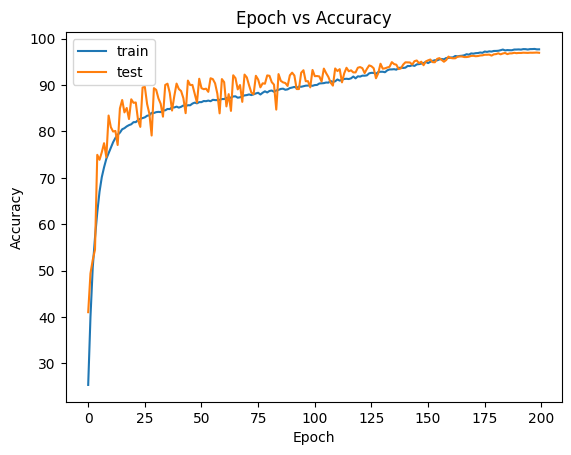

In [20]:
plt.plot(arr_train_acc)
plt.plot(arr_test_acc)
plt.legend(["train","test"])
plt.title("Epoch vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

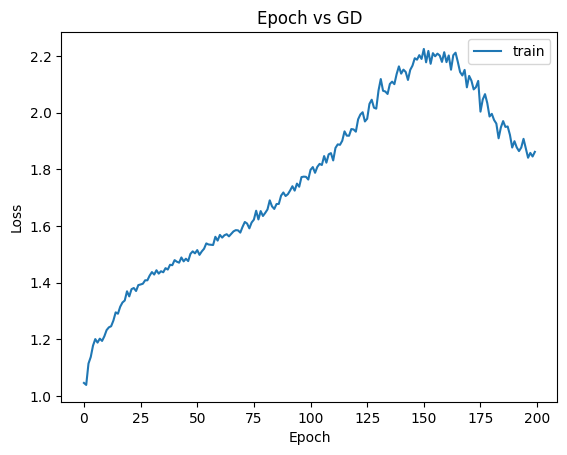

In [21]:
plt.plot(plot_gd_norm_fin)
# plt.plot(arr_test)
plt.legend(["train"])
plt.title("Epoch vs GD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

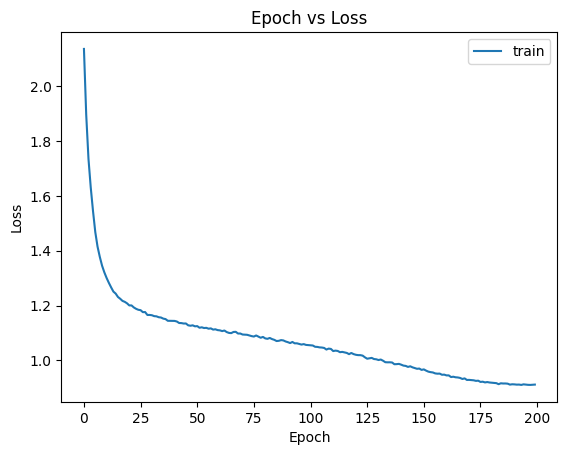

In [22]:
plt.plot(plot_train_loss_fin)
# plt.plot(arr_test)
plt.legend(["train"])
plt.title("Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

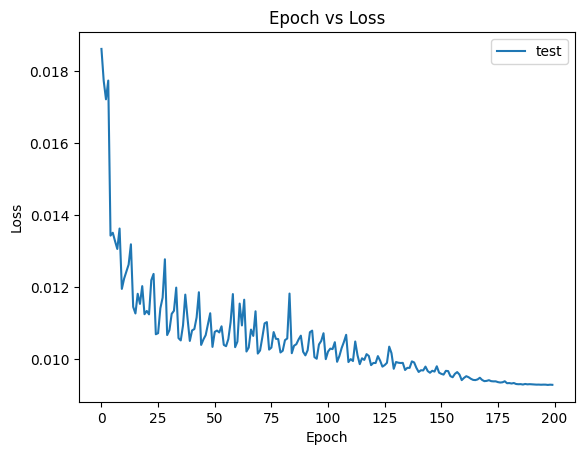

In [23]:
# plt.plot(arr_train1)
plt.plot(arr_test)
plt.legend(["test"])
plt.title("Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [24]:
model = torch.load(os.path.join(model_save_path, 'best_model.pt'), weights_only = False)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/serialization.py:1328: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(


In [25]:
# Custom Test Data Loader

class Cifar10NoLabelDataset(VisionDataset):

    def __init__(
        self,
        root: Union[str, Path],
        transform: Optional[Callable] = None
    ) -> None:
        
        super().__init__(root, transform=transform, target_transform=None)

        self.data: Any = []
        self.targets = []
        
        with open(root, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')

        
        self.data = batch[b'data']
        self.targets = batch[b'ids']
        # self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        # self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img, target = self.data[index], self.targets[index]

        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [26]:
test_tranform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_data_no_label = Cifar10NoLabelDataset(test_data_dir, transform=test_tranform)
test_loader_no_label = torch.utils.data.DataLoader(test_data_no_label, batch_size=test_batch_size, shuffle=False, num_workers=num_of_workers)

In [27]:
indexes = []
predictions = []
for batch_idx, (inputs,index) in enumerate(test_loader_no_label):
        inputs, index = inputs.to(device), index.to(device)
        indexes.extend(index.cpu().tolist())
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(torch.tensor(predicted).cpu().tolist())
        

dictionary = {'ID':indexes,'Label':predictions}
print(len(indexes))
print(len(predictions))

df = pd.DataFrame(dictionary)

<ipython-input-27-a3a93c7bf7ee>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions.extend(torch.tensor(predicted).cpu().tolist())


10000
10000


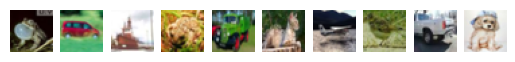

In [28]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(test_data_no_label.data[i])
    plt.axis('off')
plt.show()

In [29]:
df.loc[0:9]

,ID,Label
0,0,6
1,1,1
2,2,8
3,3,6
4,4,9
5,5,3
6,6,0
7,7,2
8,8,9
9,9,5


In [30]:
df.to_csv('out.csv',index=False)